### Import

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

import networkx as nx
import itertools

sns.set()

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

---

Load filtered data:

In [3]:
business_df = pd.read_csv('data/las_vegas_all_business.csv')
review_df = pd.read_csv('data/las_vegas_all_reviews.csv')
user_df = pd.read_csv('data/las_vegas_all_users.csv')

Filter data further according to certain category:

In [4]:
# Filter business_id according to the category
filter_business_id = business_df[business_df.categories.str.contains(r"(Hotels, )|(, Hotels$)", regex = True)].business_id

C:\Users\hanlu\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
# Filter businesses
business_df = business_df[business_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1)

In [6]:
# Filter reviews based on business_id
review_df = review_df[review_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1)

---

### NLP

* Tokenize the review texts:

Lemmatizer is utilized here instead of stemmer since lemmatizing considers context, so it is more accurate to some extent.

In [7]:
# function to test if something is an adjective or adverb
is_adj = (lambda pos: pos[:2] == 'JJ')
is_adv = (lambda pos: pos[:2] == 'RB')

In [8]:
# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the non-alphanumeric characters with space
    text = re.sub(r'[\W]', ' ', text)

    # Tokenize texts into lists of tokens
    words = word_tokenize(text)    
   
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
#     p_stemmer = PorterStemmer()
#     words = [p_stemmer.stem(word.lower()) for word in words if word not in string.punctuation]    # Remove puncatuation and set words to lowercase
   
    words = [word.lower() for word in words if word not in string.punctuation]    # Remove punctuation and set words to lowercase
    words = [word for word in words
                 if word not in stop_words
                 if len(word) > 1]    # Remove stopwords and letters (stopwords are lowercase, so this step should be done after word.lower())
#     words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos) or is_adv(pos)]    # Keep adjectives and adverbs only
    words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos)]    # Keep adjectives and adverbs only

    return words

* Compute TF-IDF scores to extract key words of each business:

> Compute TF score of each business

In [9]:
# Function for computing TF (using different methods)
def tf(df, tf_method='term_frequency'):

    # Create a nested dictionary for {business: {word: tf score}} storing term-frequency
    term_frequency = {}
    for business_id in df.business_id.unique():
        # Create a dictionary for each business to store words and counts of words
        term_frequency[business_id] = {}

        # Concatenate all reviews of a specific business into one text
        business_text = ' '.join(df[df.business_id==business_id].text)
        # Total word amount for one business (for tf_method=='term_frequency')
        total_word_amount = len(business_text)
        # Tokenize the text into a list of words
        words = tokenize_text(business_text)
        # Count words
        for word in words:
            if word not in term_frequency[business_id].keys():
                term_frequency[business_id][word] = 1
            else:
                term_frequency[business_id][word] += 1       

        # Compute different types of term frequency
        if tf_method == 'raw_count':
            term_frequency = term_frequency

        elif tf_method == 'term_frequency':
            term_frequency[business_id] = {k : v/total_word_amount for k, v in term_frequency[business_id].items()}

        elif tf_method == 'log':
            term_frequency[business_id] = {k : math.log(1 + v) for k, v in term_frequency[business_id].items()}

        elif tf_method == 'double_normalization':
            term_frequency[business_id] = {k : (0.5 + 0.5*v/max(term_frequency[business_id].values())) for k, v in term_frequency[business_id].items()}        

    return term_frequency

> Compute IDF score for each business

In [10]:
# Function for computing IDF (using different methods)
def idf(df, term_frequency, idf_method='idf'):
    # Total number of documents (i.e. total number of businesses in this case, because we concatenate all the reviews of one specific business)
    N = len(df.business_id.unique())
    
    # Create a nested dictionary for {business: {word: idf score}} storing term-frequency
    inverse_document_frequency = {}
    
    for business1 in term_frequency.keys():
        # Update the idf dictionary into form as {business: {word: 0}}
        inverse_document_frequency[business1] = {k : 0 for k in term_frequency[business1].keys()}
        
        for word in term_frequency[business1]:
            # If a specific word occurs in another business, add 1 to the count of this word
            for business2 in term_frequency.keys():
                if word in term_frequency[business2].keys():
                    inverse_document_frequency[business1][word] += 1
        
        # Compute different types of inverse document frequency based on the number of occurance of a word in all the businesses
        if idf_method == 'idf':
            inverse_document_frequency[business1] = {k : math.log(N/v) for k, v in inverse_document_frequency[business1].items()}
        elif idf_method == 'idf_smooth':
            inverse_document_frequency[business1] = {k : (math.log(N/(1+v))+1) for k, v in inverse_document_frequency[business1].items()}
    
    
    return inverse_document_frequency

> Compute TF-IDF score

In [11]:
# Function for computing TD-IDF score
def tf_idf(df, tf_method='term_frequency', idf_method='idf'):
    
    term_frequency = tf(df, tf_method='term_frequency')
    inverse_document_frequency = idf(df, term_frequency=term_frequency, idf_method='idf')
    
    tf_idf = {}
    for business in term_frequency:
        tf_idf[business] = {k : v*term_frequency[business][k] for k,v in inverse_document_frequency[business].items()}
    
    return tf_idf

* Join review and business data frames and calculate TF-IDF score:

In [12]:
business_review_df = pd.merge(business_df, review_df, on='business_id', how='outer')

In [13]:
business_review_df.head(1)

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars_x  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396      1.5           154   

   ...                                         categories hours  \
0  ...  Hotels & Travel, Hotels, Event Planning & Serv...    {}   

                review_id                 user_id stars_y useful  funny  cool  \
0  h4mPmRnFUgekEvtbvXMeWw  ANGEDyzIN7xlEOdxe5U5Wg     1.0      0      0     0   

                                                text                 date  
0  Went to the presentation and spent 4 hours the...  2018-06-19 18:13:32  

[1 rows x 22 columns]

In [14]:
business_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
start_time = time.time()

tf_idf_score = tf_idf(business_review_df)

end_time = time.time()

In [ ]:
end_time-start_time ## 17 min = YG MacBook Pro time (in seconds)

In [ ]:
end_time-start_time ## 19.5 min = SS Dell XPS time (in seconds)

In [ ]:
tf_idf_score.keys()

In [ ]:
sorted(tf_idf_score.get('p0iEUamJVp_QpaheE-Nz_g'), key=lambda x:x[1], reverse=True)

---

### Graphs & Network science:

In [20]:
def retrieve_top_n_keywords_from_all_business(n):
    
    # Final dict, which will contain top N keywords for each business
    top_keywords_dict = {}
    
    # For each business, we will save its business_id and its top N keywords in a dictionary
    for business_id, term_dict in tf_idf_score.items():
        
        # Sort the terms by their TF-IDF score (descendingly), and keep the top N
        top_n_keywords_list = [TFIDF_tuple[0] for TFIDF_tuple in sorted(term_dict.items(), key = (lambda x : x[1]), reverse = True)][0:n]
        
        top_keywords_dict[business_id] = list(top_n_keywords_list)
        
    return top_keywords_dict

In [21]:
# n = how many top keywords should the network check for nodes to have in common
n = 10

top_keywords_dict = retrieve_top_n_keywords_from_all_business(n)

In [22]:
top_keywords_dict

{'izw7OBVSeNmlVhjly1amQg': ['wyndham',
  'timeshare',
  'interested',
  'drake',
  'salespeople',
  'free',
  'salesperson',
  'wynhdam',
  'scam',
  'representative'],
 'tzlm9Im_8h144lDuIi4o1Q': ['raven',
  'laced',
  'horseless',
  'tranest',
  'succor',
  'oats',
  'stove',
  'phase',
  'staffs',
  'firewall'],
 'mv9CWDyMw5jgFmtrJePN3w': ['fabulicious',
  'bounteous',
  'elicit',
  'rrr',
  'haunted',
  'regarded',
  'disco',
  'unsurpassed',
  'delectable',
  'vegetarian'],
 'vchjO0Vs5FwW2tpFnCimqg': ['ph',
  'suite',
  'washer',
  'full',
  'couch',
  'projector',
  'modern',
  'westgate',
  'huge',
  'nice'],
 '8kWUrcPJNzVsVqt0xtzrdg': ['experian',
  'nish',
  'shiiii',
  'fora',
  'lippy',
  'faulty',
  'berserk',
  'scrapped',
  'beatable',
  'beleive'],
 'FUhJLCocwgZEiVn1Wg1KSg': ['serene',
  'cliff',
  'tub',
  'dirty',
  'shower',
  'hot',
  'remote',
  'front',
  'portray',
  'clean'],
 '24S-aiManGfjbb-fwwi2VQ': ['quinta',
  'continental',
  'nevada',
  'sanitize',
  'dirty

Already now, we can create a network graph, and initialize a node for every unique business_id:

In [23]:
G = nx.Graph()

# Adding nodes
G.add_nodes_from(top_keywords_dict.keys())

print('Initially, the total number of nodes/businesses in the network is:', G.number_of_nodes())

Initially, the total number of nodes/businesses in the network is: 438


In [24]:
# We will remodel the "Top Keywords" dictionary into a dataframe in long-format, where each row corresponds to a (business_id, unique_keyword) combination
# We want this specific form for the dataframe, so that we can group by keywords afterwards, and identify which businesses have keywords in common
# A .reset_index() is needed here, in order to add an dummy extra column for the "groupby" function to perform a "count" operation into.

keyword_df = pd.DataFrame(top_keywords_dict).melt(var_name = 'business_id', value_name = 'keywords').reset_index()

In [25]:
# Group keywords by 'business_id', to find the businesses sharing top keywords

grouped_keyword_df = keyword_df.groupby(['keywords', 'business_id']).count()['index']

In [26]:
# Here, we are interating through the grouped set of keywords, 
# and if two businesses have the same keyword in common, we will create a network edge between the two busineses

for _, business_sub_df in grouped_keyword_df.groupby(level = 0):
    
    # This is a list of combinations of 2 businesses which have the same top keyword in common
    edges_list = list(itertools.combinations(business_sub_df.droplevel(0).index, 2))
    
    for node1, node2 in edges_list:
        
        if G.has_edge(node1, node2):
            # we added this connection before, just increase the weight by one
            G[node1][node2]['weight'] += 1
            
        else:
            # new edge, therefore initialize link with weight = 1
            G.add_edge(node1, node2, weight = 1)

In [27]:
print('Using the top n = %d keywords from TF-IDF, the initialized number of edges is: %d' % (n, G.number_of_edges()))

Using the top n = 10 keywords from TF-IDF, the initialized number of edges is: 10791


In [28]:
# Remove the isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes outside the main connected component (i.e. outside the GCC)
for component in list(nx.connected_components(G.to_undirected())):
    if (len(component) < 5):
        for node in component:
            G.remove_node(node)

print('After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is:', G.number_of_nodes())
print('Also, the number of edges present in the network now is:', G.number_of_edges())

After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is: 421
Also, the number of edges present in the network now is: 10790


---

### Plotting of network graph:

In [29]:
from fa2 import ForceAtlas2 as FA2

# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.56it/s]

BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  5.81  seconds
Gravitational forces  took  0.16  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


In [30]:
node_sizes = []

for node in G:
    
    total_reviews = business_df[business_df.business_id == node].review_count
    
    # Append the appropriate size to a node
    node_sizes.append(total_reviews * 0.025)

In [31]:
labels = nx.get_edge_attributes(G,'weight')
print(list(set(labels.values())))

[1, 2, 3, 4, 5, 6, 7]


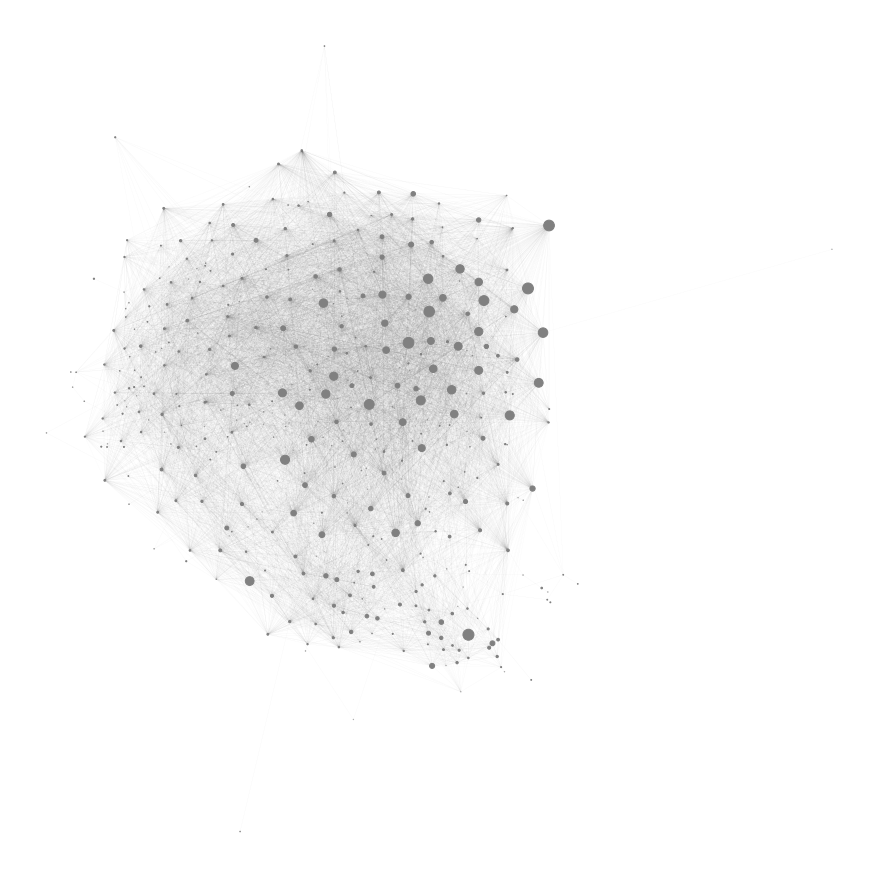

In [32]:
plt.figure(figsize = (12, 12))
plt.tight_layout()

nx.draw(G, pos = positions, node_size = node_sizes, node_color = 'grey', width = 0.01)

Looks like a Barabasi-Albert network, with some central hubs (with large size, because of their lots of reviews), which get connected together with many smaller nodes (with less reviews).

This clearly shows that there are some hotels which are very popular and attract most clients, and the black mass of edges inside the center shows that these hotels are each other's strong competitors, since the same clients have consequently gone to these hotels, thereby linking them together in our network.

The network edges are weight-adjusted depending on their frequency, with higher thickness/weight meaning higher frequency.

In [33]:
degree_list = [x[1] for x in list(G.degree())]

max_degree = max(degree_list)
min_degree = min(degree_list)

print('The maximum degree in our network is:', max_degree)
print('The minimum degree in our network is:', min_degree)

The maximum degree in our network is: 160
The minimum degree in our network is: 1


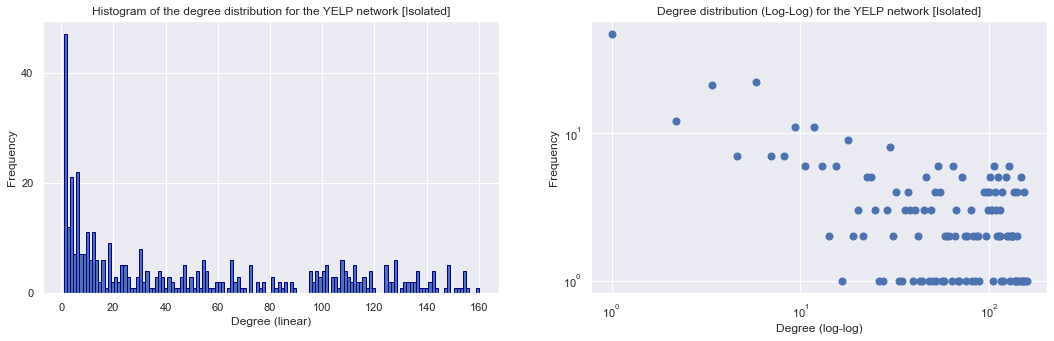

In [34]:
hist, bins = np.histogram(degree_list, bins = len(set(degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(degree_list, bins = bins, ec = "darkblue")
axs[0].set_title('Histogram of the degree distribution for the YELP network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 20));
axs[0].set_xlabel('Degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Degree distribution (Log-Log) for the YELP network [Isolated]')
axs[1].set_xlabel('Degree (log-log)')
axs[1].set_ylabel('Frequency');

---
### Interactive visualization of our graph:

In [36]:
import plotly.graph_objects as go

In [60]:
fig = go.Figure()

for node1_id, node2_id in G.edges.keys():
    node1 = business_df[business_df.business_id == node1_id]
    node2 = business_df[business_df.business_id == node2_id]
    
    lon = [node1.longitude, node2.longitude]
    lat = [node1.latitude, node2.latitude]
    
    fig.add_trace(go.Scattermapbox(
        mode="markers+text+lines",
        lon=lon,
        lat=lat
    ))
    
fig.update_layout(
        margin={'l': 0, 't': 0, 'b': 0, 'r': 0},
        mapbox={
            
            'accesstoken': 'pk.eyJ1Ijoic2VieS1zYmlybmEiLCJhIjoiY2tpZG1vd3h3MHRoYjJ4bzVzNHdnbDVvaCJ9.Z-ZMrTkf_0kGPXRkitJGHA',
            'style': "outdoors",
            'center': go.layout.mapbox.Center(lat = 36.1699, lon = -115.1398),
            'zoom': 11}
)

fig.show()

### Don't run anything below it~

In [61]:
# Inserted an error here to stop it from running

break

SyntaxError: 'break' outside loop (<ipython-input-61-6aaf1f276005>, line 4)

In [123]:
# Setting the "pos" node argument, representing the node positioning computed from the Force-Atlas 2

for node, pos in positions.items():
    G.nodes[node]['pos'] = pos

In [134]:
G_test = nx.random_geometric_graph(200, 0.125)

In [101]:
ordered_node_sizes = [float(node.values) for node in node_sizes]

In [133]:
import igviz as YG

In [ ]:
fig = YG.plot(G, 
              title = 'Visualization of the Hotels in Las Vegas (as nodes), using Force-Atlas node positions',
              size_method = "static")

fig.show()

In [ ]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title='Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
               )
fig.show()

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396    1.5           154   

   is_open                                         attributes  \
0        1  {"BusinessAcceptsCreditCards": "True", "Restau...   

                                          categories hours  
0  Hotels & Travel, Hotels, Event Planning & Serv...    {}

In [179]:
fig = go.Figure(go.Scattermapbox(
    name = "",
    mode = "markers+text+lines",
    lon = [-75, -80],
    lat = [45, 20],
    marker = {'size': 20, 'symbol': ["bus", "harbor", "airport"]},
    hovertemplate =
    "<b>%{marker.symbol} </b><br><br>" +
    "longitude: %{lon}<br>" +
    "latitude: %{lat}<br>" ))

fig = go.Figure(go.Scattermapbox(
    name = "",
    mode = "markers+text+lines",
    lon = [-80, -50],
    lat = [20, -20],
    marker = {'size': 20, 'symbol': ["bus", "harbor", "airport"]},
    hovertemplate =
    "<b>%{marker.symbol} </b><br><br>" +
    "longitude: %{lon}<br>" +
    "latitude: %{lat}<br>" ),
               layout=go.Layout(
                   title='<br>Network graph made with Python',
                   margin=dict(b=0,l=0,r=0,t=55)))

fig.update_layout(
    mapbox = {
        'accesstoken': 'pk.eyJ1Ijoic2VieS1zYmlybmEiLCJhIjoiY2tpZG1vd3h3MHRoYjJ4bzVzNHdnbDVvaCJ9.Z-ZMrTkf_0kGPXRkitJGHA',
        'style': "outdoors", 'zoom': 1},
    showlegend = False)

fig.show()

---
### Community detection:

* Louvain algorithm

In [37]:
import community

# Find the best community partition for the DC universe
partition_hotels = community.best_partition(G, random_state = 3)

print("The Louvain algorithm has found", len(set(partition_hotels.values())), "communities for hotel landscape in Las Vegas.")

The Louvain algorithm has found 4 communities for hotel landscape in Las Vegas.


In [38]:
# For this visualization, let's create a modifiable copy of the DC subgraph
viz_hotels_graph = G.copy()

# Split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_hotels.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_hotels.items() if comm == community_nr]

In [39]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

positions = forceatlas2.forceatlas2_networkx_layout(viz_hotels_graph, pos = None, iterations = 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.28it/s]

BarnesHut Approximation  took  0.89  seconds
Repulsion forces  took  6.05  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


In [40]:
character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED', '#FF1493', '#FFD700', '#4169E1', '#FF0000', '#7FFF00', '#808080', '#3DFA23', '#ABB351']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in viz_hotels_graph:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(viz_hotels_graph.degree(node) * 0.6)

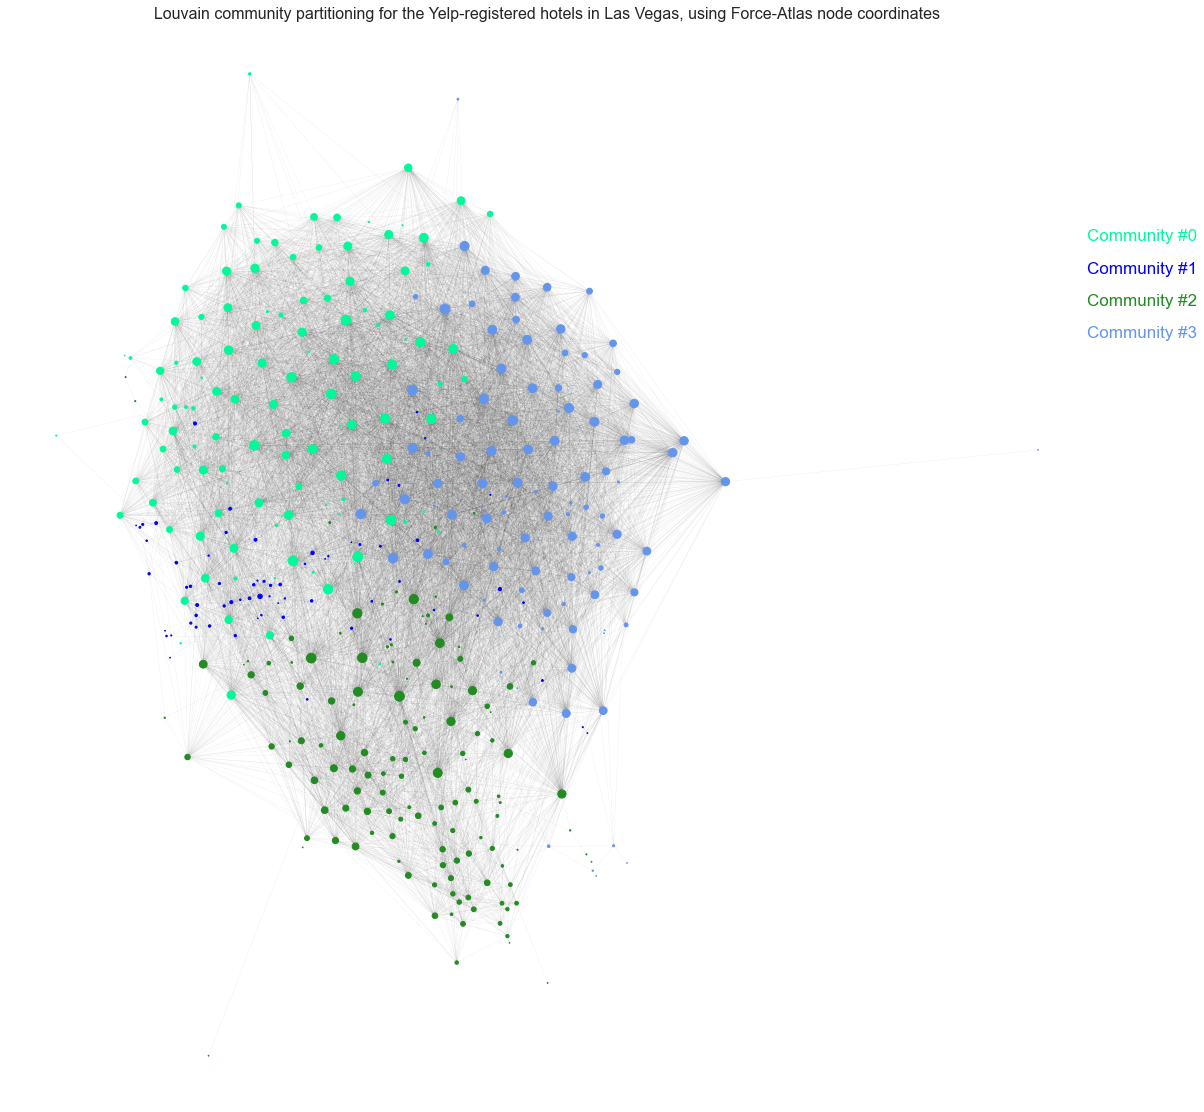

In [41]:
plt.figure(figsize = (15, 15))

nx.draw(viz_hotels_graph, pos = positions, node_size = node_size_list, node_color = node_color_list, width = 0.025)

y = 0.80 # This is the starting Y, for the figure text
# Indicating community colors
for i in dict_communities.keys():
    plt.figtext(1, y, str('Community #' + str(i)), size = 17, color = community_color_list[i])
    y = y - 0.03

plt.title("Louvain community partitioning for the Yelp-registered hotels in Las Vegas, using Force-Atlas node coordinates", fontsize = 16);

In [59]:
G.edges(data = True)

EdgeDataView([('izw7OBVSeNmlVhjly1amQg', '-0qht1roIqleKiQkBLDkbw', {'weight': 2}), ('izw7OBVSeNmlVhjly1amQg', '-hsFN8VQvH26M0WZ3k1Wtg', {'weight': 2}), ('izw7OBVSeNmlVhjly1amQg', '1SeD2yu2GDQ_RUQy97tP3A', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', '5VIKIaq1qYQL-2Of2VCuEg', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', '5Zc41a446gV3K_o7CDs69Q', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', '7zec5DCEukcx8GRFn9LbLQ', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'AMBRlzxRFtdduObZlw8UPQ', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'BI3kK6a6ko6yfz9TviQ7Aw', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'ByFMv3p5X1aNeZhU61rDcA', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'Ccjo5j4A5-gVaBbuHAqzVA', {'weight': 2}), ('izw7OBVSeNmlVhjly1amQg', 'LkMtMHVetws5_7QfRjPtlg', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'LxPNKVBrbqIHog3MI-rkDQ', {'weight': 1}), ('izw7OBVSeNmlVhjly1amQg', 'MFs5_vACoLxdB5eUB5fXeg', {'weight': 4}), ('izw7OBVSeNmlVhjly1amQg', 'OIOqy9gh3LOoyso3JMwyyA', {'weight': 1}), ('izw7OBVSeNmlVhjly1

---
---
---

In [42]:
print(set((', '.join(business_df[business_df.business_id.isin(dict_communities[0])].categories.to_list())).split(', ')))

{'Music Venues', 'Apartments', 'Hostels', 'Restaurants', 'Italian', 'Coffee & Tea', 'Food', 'Active Life', 'Nightlife', 'Beauty & Spas', 'Event Planning & Services', 'Sushi Bars', 'Home Services', 'Vacation Rental Agents', 'RV Parks', 'Employment Agencies', 'Hair Salons', 'Barbers', 'Campgrounds', 'RV Rental', 'Airports', 'Massage', 'Bed & Breakfast', 'Car Dealers', 'Real Estate Services', 'American (Traditional)', 'Caterers', 'Travel Services', 'Professional Services', 'Museums', 'Resorts', 'Hotels', 'Guest Houses', 'Automotive', 'Adult Entertainment', 'Casinos', 'Tennis', 'Japanese', 'Bars', 'Venues & Event Spaces', 'Hotels & Travel', 'Arts & Entertainment', 'Real Estate', 'Lounges', 'Steakhouses', 'Wedding Planning', 'Vacation Rentals', 'Party & Event Planning'}


In [43]:
print(set((', '.join(business_df[business_df.business_id.isin(dict_communities[1])].categories.to_list())).split(', ')))

{'Local Services', 'Music Venues', 'Personal Assistants', 'Car Rental', 'Apartments', 'Hostels', 'Dance Clubs', 'Restaurants', 'Town Car Service', 'Food', 'Club Crawl', 'Beauty & Spas', 'Nightlife', 'Event Planning & Services', 'Active Life', 'Home Services', 'Transportation', 'Tours', 'Dry Cleaning & Laundry', 'Personal Shopping', 'Airport Shuttles', 'Day Spas', 'Travel Services', 'Limos', 'Professional Services', 'Cocktail Bars', 'Resorts', 'Dry Cleaning', 'Shopping', 'Hotels', 'Swimming Pools', 'Laundry Services', 'Taxis', 'Adult Entertainment', 'Casinos', 'Beaches', 'Marketing', 'Bars', 'Venues & Event Spaces', 'Property Management', 'Hotels & Travel', 'Arts & Entertainment', 'Security Services', 'Real Estate', 'Diners', 'Lounges', 'Steakhouses', 'Party Bus Rentals', 'Vacation Rentals', 'Party & Event Planning'}


In [44]:
print(set((', '.join(business_df[business_df.business_id.isin(dict_communities[2])].categories.to_list())).split(', ')))

{'Italian', 'Cinema', 'Home Services', 'Indian', 'Hair Salons', 'Campgrounds', 'Barbers', 'Transportation', 'Tours', 'Fast Food', 'Chicken Wings', 'Comfort Food', 'Travel Services', 'Resorts', 'Barbeque', 'Pizza', 'Pakistani', 'Hotels & Travel', 'Bowling', 'Wedding Planning', 'Amusement Parks', 'Vacation Rentals', 'Party & Event Planning', 'Bar Crawl', 'Do-It-Yourself Food', 'Breakfast & Brunch', 'Sports Bars', 'Wine & Spirits', 'Event Planning & Services', 'Mexican', 'Hong Kong Style Cafe', 'Wine Bars', 'Day Spas', 'Limos', 'Asian Fusion', 'Adult Entertainment', 'Casinos', 'Bars', 'Venues & Event Spaces', 'Seafood', 'Property Management', 'Walking Tours', 'Real Estate', 'Party Supplies', 'Beer', 'Mediterranean', 'Spanish', 'Burgers', 'Hostels', 'Beauty & Spas', 'Nightlife', 'Cosmetics & Beauty Supply', 'Salad', 'Bus Tours', 'Watches', 'Arcades', 'Rest Stops', 'Soup', 'Hotels', 'Shopping', 'Japanese', 'Food Tours', 'Wedding Chapels', 'Chinese', 'Delis', 'Steakhouses', 'French', 'Shared

In [45]:
print(set((', '.join(business_df[business_df.business_id.isin(dict_communities[3])].categories.to_list())).split(', ')))

{'Airport Lounges', 'Cinema', 'Italian', 'Flowers & Gifts', 'Leather Goods', 'Home Services', 'Indian', 'Hair Salons', 'Cabaret', 'Barbers', 'Massage', 'Fast Food', 'Travel Services', 'Resorts', 'Swimming Pools', 'Sandwiches', 'Hotels & Travel', 'Striptease Dancers', 'Bowling', 'Wedding Planning', 'Vacation Rentals', 'Dive Bars', 'Sports Bars', 'Car Wash', 'Wine & Spirits', 'Event Planning & Services', 'Cajun/Creole', 'Day Spas', 'Caterers', 'Gift Shops', 'Adult Entertainment', 'Casinos', 'Bars', 'Venues & Event Spaces', 'Real Estate', 'Fitness & Instruction', 'Beer', 'Hostels', 'Gyms', 'Beauty & Spas', 'Nightlife', 'Airports', 'Home Cleaning', 'Home Decor', 'Home & Garden', 'Shopping', 'Hotels', 'Translation Services', 'Convenience Stores', 'Golf', 'Delis', 'Ski Resorts', 'American (New)', 'Music Venues', 'Apartments', 'Strip Clubs', 'Shopping Centers', 'Restaurants', 'Dance Clubs', 'Coffee & Tea', 'Food', 'Fashion', 'Performing Arts', 'Active Life', 'Vacation Rental Agents', 'Pool Ha

In [46]:
set((', '.join(business_df[business_df.business_id.isin(dict_communities[0])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[1])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[2])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[3])].categories.to_list())).split(', '))

{'Car Dealers',
 'Employment Agencies',
 'Museums',
 'RV Rental',
 'Real Estate Services',
 'Tennis'}

In [47]:
set((', '.join(business_df[business_df.business_id.isin(dict_communities[1])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[0])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[2])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[3])].categories.to_list())).split(', '))

{'Airport Shuttles',
 'Beaches',
 'Car Rental',
 'Club Crawl',
 'Dry Cleaning',
 'Dry Cleaning & Laundry',
 'Laundry Services',
 'Marketing',
 'Personal Assistants',
 'Personal Shopping',
 'Security Services',
 'Taxis',
 'Town Car Service'}

In [48]:
set((', '.join(business_df[business_df.business_id.isin(dict_communities[2])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[1])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[0])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[3])].categories.to_list())).split(', '))

{'Amusement Parks',
 'Arcades',
 'Asian Fusion',
 'Bar Crawl',
 'Barbeque',
 'Bingo Halls',
 'Breakfast & Brunch',
 'Buffets',
 'Burgers',
 'Bus Tours',
 'Chicken Wings',
 'Chinese',
 'Comfort Food',
 'Commercial Real Estate',
 'Cosmetics & Beauty Supply',
 'Dim Sum',
 'Do-It-Yourself Food',
 'Food Tours',
 'French',
 'Gas Stations',
 'Greek',
 'Hong Kong Style Cafe',
 'Mediterranean',
 'Mexican',
 'Noodles',
 'Pakistani',
 'Party Supplies',
 'Piano Bars',
 'Pizza',
 'Rest Stops',
 'Salad',
 'Seafood',
 'Shared Office Spaces',
 'Skating Rinks',
 'Soup',
 'Spanish',
 'Teppanyaki',
 'Ticket Sales',
 'Walking Tours',
 'Watches',
 'Wedding Chapels',
 'Wine Bars'}

In [49]:
set((', '.join(business_df[business_df.business_id.isin(dict_communities[3])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[1])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[2])].categories.to_list())).split(', ')) - set((', '.join(business_df[business_df.business_id.isin(dict_communities[0])].categories.to_list())).split(', '))

{'Airport Lounges',
 'Cabaret',
 'Cajun/Creole',
 'Car Wash',
 'Convenience Stores',
 'Dive Bars',
 'Fashion',
 'Fitness & Instruction',
 'Flowers & Gifts',
 'Gift Shops',
 'Golf',
 'Gyms',
 'Home & Garden',
 'Home Cleaning',
 'Home Decor',
 'Leather Goods',
 'Musicians',
 'Nail Salons',
 'Performing Arts',
 'Pool Halls',
 'Pubs',
 'Sandwiches',
 'Shopping Centers',
 'Ski Resorts',
 'Skin Care',
 'Strip Clubs',
 'Striptease Dancers',
 'Translation Services'}